# chapter 5-1 データセットの取得と活用

# 自然言語処理技術を用いた頻出単語の抽出

In [15]:
%%writefile mecab_sample.py

# MeCabをPythonから使う

import MeCab

tagger = MeCab.Tagger()
tagger.parse('') # これは.parseToNode()の不具合を回避するのに必要

# .parseToNode()で最初の形態素を表すNodeオブジェクトを取得する
node = tagger.parseToNode('すもももももももものうち')

while node:
    # .surfaceは形態素の文字列、.featureは品詞などを含む文字列をそれぞれ表す
    print(node.surface, node.feature)
    node = node.next # .nextで次のNodeを取得する

Overwriting mecab_sample.py


In [16]:
!python mecab_sample.py

 BOS/EOS,*,*,*,*,*,*,*,*
すもも 名詞,一般,*,*,*,*,すもも,スモモ,スモモ
も 助詞,係助詞,*,*,*,*,も,モ,モ
もも 名詞,一般,*,*,*,*,もも,モモ,モモ
も 助詞,係助詞,*,*,*,*,も,モ,モ
もも 名詞,一般,*,*,*,*,もも,モモ,モモ
の 助詞,連体化,*,*,*,*,の,ノ,ノ
うち 名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ
 BOS/EOS,*,*,*,*,*,*,*,*


# 文章から頻出単語を抽出する

In [21]:
%%writefile word_frequency.py

# Wikipediaの文章から頻出単語を抜き出す

import sys
import os
from glob import glob
from collections import Counter
import MeCab

def main():
    """
    コマンドライン引数で指定したディレクトリ内のファイルを読み込んで頻出単語を抽出する
    """
    
    input_dir = sys.argv[1] # コマンドラインの第1引数でWikiExtractorの出力先のディレクトリを指定する
    
    tagger = MeCab.Tagger('')
    tagger.parse('') # .parseToNode()の不具合を回避するのに必要
    # 単語の頻度を格納するCounterオブジェクトを作成する
    # Counterクラスはdictを継承しており、値としてキーの出現回数を保持する
    frequency = Counter()
    count_proccessed = 0
    
    # glob()でワイルドカードにマッチするファイルのリストを取得し、マッチしたすべてのファイルを処理する
    for path in glob(os.path.join(input_dir, '*', 'wiki_*')):
        print('Proccessing {0}...'.format(path), file=sys.stderr)
        
        with open(path) as file: # ファイルを開く
            for content in iter_docs(file): # ファイル内の全記事について反復処理する
                tokens = get_tokens(tagger, content) # ページから名詞のリストを取得する
                # Counterのupdate()メソッドにリストなどの反復可能オブジェクトを指定すると、
                # リストに含まれる値の出現回数を一度に増やせる
                frequency.update(tokens)
                
                # 10,000件ごとに進捗を表示
                count_proccessed += 1
                if count_proccessed % 10000 == 0:
                    print('{0} documents were proccessed.'.format(count_proccessed),
                         file=sys.stderr)
                    
    # 全記事の処理が完了したら上位30件の名詞と出現回数を表示する
    for token, count in frequency.most_common(30):
        print(token, count)
        
        
def iter_docs(file):
    """
    ファイルオブジェクトを読み込んで、記事の中身(開始タグ<doc ...>と終了タグ</doc>の間のテキスト)を
    順に返すジェネレーター関数
    """
    
    for line in file:
        if line.startswith('<doc '):
            buffer = [] # 開始タグが見つかったらバッファを初期化する
        elif line.startswith('</doc>'):
            # 終了タグが見つかったらバッファの中身を結合してyieldする
            content = ''.join(buffer)
            yield content
        else:
            buffer.append(line) # 開始タグ・終了タグ以外の業はバッファに追加する
            
            
def get_tokens(tagger, content):
    """
    文書内に出現した名詞のリストを取得する関数
    """
    
    tokens = [] # この記事で出現した名詞を格納するリスト
    
    node = tagger.parseToNode(content)
    while node:
        # node.featureはカンマで区切られた文字列なので、split() で分割して
        # 最初の2項目をcategoryとsub_categoryに代入する
        category, sub_category = node.feature.split(',')[:2]
        # 固有名詞または一般名詞の場合のみtokensに追加する
        if category == '名詞' and sub_category in ('固有名詞', '一般'):
            tokens.append(node.surface)
        node = node.next
        
    return tokens


if __name__ == '__main__':
    main()

Writing word_frequency.py


In [22]:
!python word_frequency.py articles

Proccessing articles/AA/wiki_00...
10000 documents were proccessed.
Proccessing articles/AA/wiki_01...
20000 documents were proccessed.
30000 documents were proccessed.
Proccessing articles/AA/wiki_02...
40000 documents were proccessed.
50000 documents were proccessed.
Proccessing articles/AA/wiki_03...
60000 documents were proccessed.
70000 documents were proccessed.
Proccessing articles/AA/wiki_04...
80000 documents were proccessed.
月 298912
日本 130996
時代 65654
駅 51080
世界 46833
作品 44752
番組 43670
列車 43488
昭和 42446
東京 41921
一般 38469
地域 37079
鉄道 37058
平成 36889
中心 36282
アメリカ 36205
ホーム 31774
世紀 30718
バス 30405
大学 30271
車両 29862
間 29861
路線 29207
映画 28781
他 28559
学校 27057
形 26538
ドイツ 26472
事業 26380
テレビ 26332


# chapter 5-2 APIによるデータの収集と活用

# Twitterからのデータの収集

# Requests-OAuthlibを使ったTwitter REST APIの利用

In [8]:
%%writefile rest_api_with_requests_oauthlib.py

# Requests-OAuthlibを使ってタイムラインを取得する

import os
from requests_oauthlib import OAuth1Session

# 環境変数から認証情報を取得する
CONSUMER_KEY = os.environ['CONSUMER_KEY']
CONSUMER_SECRET = os.environ['CONSUMER_SECRET']
ACCESS_TOKEN = os.environ['ACCESS_TOKEN']
ACCESS_TOKEN_SECRET = os.environ['ACCESS_TOKEN_SECRET']

# 認証情報を使ってOAuth1Sessionオブジェクトを得る
twitter = OAuth1Session(CONSUMER_KEY,
                       client_secret=CONSUMER_SECRET,
                       resource_owner_key=ACCESS_TOKEN,
                       resource_owner_secret=ACCESS_TOKEN_SECRET)

# ユーザーのタイムラインを取得する
response = twitter.get('https://api.twitter.com/1.1/statuses/home_timeline.json')

# APIのレスポンスはJSON形式なので、response.json()でパースしてlistを取得できる
# statusはツイート(Twitter APIではStatusと呼ばれる)を表すdict
for status in response.json():
    print('@' + status['user']['screen_name'], status['text']) # ユーザー名とツイートを表示する

Overwriting rest_api_with_requests_oauthlib.py


In [ ]:
!forego run python rest_api_with_requests_oauthlib.py

# TweepyによるTwitter REST APIの利用

In [13]:
%%writefile rest_api_withtweepy.py

# Tweepyを使ってタイムラインを取得する

import os
import tweepy

# 環境変数から認証情報を取得する
CONSUMER_KEY = os.environ['CONSUMER_KEY']
CONSUMER_SECRET = os.environ['CONSUMER_SECRET']
ACCESS_TOKEN = os.environ['ACCESS_TOKEN']
ACCESS_TOKEN_SECRET = os.environ['ACCESS_TOKEN_SECRET']

# 認証情報を設定する
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth) # APIクライアントを取得する
public_tweets = api.home_timeline() # ユーザーのタイムラインを取得する

# 得られるツイートのオブジェクトはTweepyのStatusオブジェクト
for status in public_tweets:
    print('@' + status.user.screen_name, status.text) # ユーザー名とツイートを取得する

Overwriting rest_api_withtweepy.py


In [ ]:
!forego run python rest_api_withtweepy.py

# TweepyによるTwitter Streaming APIの利用

In [21]:
%%writefile streaming_api_with_tweepy.py

# TweepyによるStreaming APIの利用

import os
import tweepy

# 環境変数から認証情報を取得する
CONSUMER_KEY = os.environ['CONSUMER_KEY']
CONSUMER_SECRET = os.environ['CONSUMER_SECRET']
ACCESS_TOKEN = os.environ['ACCESS_TOKEN']
ACCESS_TOKEN_SECRET = os.environ['ACCESS_TOKEN_SECRET']

# 認証情報を設定する
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)


class MyStreamListener(tweepy.StreamListener):
    """
    Streaming APIで取得したツイートを処理するためのクラス
    """
    
    def on_status(self, status):
        """
        ツイートを受信した時に呼び出されるメソッド
        引数はツイートを表すStatusオブジェクト
        """
        print('@' + status.author.screen_name, status.text)
        
        
# 認証情報とStreamListenerを指定してStreamオブジェクトを取得する
stream = tweepy.Stream(auth, MyStreamListener())
# 公開されているツイートをサンプリングしたストリームを受信する
# キーワード引数languagesで日本語のツイートのみに絞り込む
stream.sample(languages=['ja'])

Overwriting streaming_api_with_tweepy.py


# Amazonの商品情報の収集

# YouTubeからの動画情報の収集

# Google API Client for Pythonを使う

In [32]:
%%writefile search_youtube_videos.py

# YouTubuの動画を検索する

import os
from apiclient.discovery import build

YOUTUBE_API_KEY = os.environ['YOUTUBE_API_KEY'] # 環境変数からAPIキーを取得する

# YouTubeのAPIクライアントを組み立てる
# build()関数の第1引数にはAPI名を、第2引数にはAPIのバージョンを指定し、
# キーワード引数developerKeyでAPIキーを指定する
# この関数には内部的にYouTube API用のURLにアクセスし、APIのリソースやメソッドの情報を取得する
youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)

# キーワード引数で引数を指定し、search.listメソッドを呼び出す
# list()メソッドでgoogleapiclient.http.HttpRequestオブジェクトが得られ、
# execute()メソッドを実行すると実際にHTTPリクエストが送られて、APIのレスポンスが得られる
search_response = youtube.search().list(
    part='snippet',
    q='手芸',
    type='video',
).execute()

# search_responseはAPIのレスポンスのJSONをパースしたdict
for item in search_response['items']:
    print(item['snippet']['title']) # 動画のタイトルを表示する

Overwriting search_youtube_videos.py


In [33]:
!forego run python search_youtube_videos.py

【購入品紹介】お気に入りの手芸屋さんで買い物♡大阪の可愛いお店
#プチプラDIY ダイソーのスエード調手芸ひもが可愛すぎる！
簡単！カチュームの作り方／広島 あとりえChikuTaku(ちくたくの手芸塾)
【手芸】トイレットペーパーの芯でミニチュアのニット帽を作る。
針も糸も使わない手芸！果たしてそんなことが可能なのか？作品のクオリティと簡単さにドランクドラゴンも驚愕！！【公式】


# 動画情報(メタデータ含む)をMongoDBに格納して検索する

In [5]:
%%writefile save_youtube_video_metadata.py

# 動画の情報をMongoDBに格納し検索可能にする

import os
import sys
from apiclient.discovery import build
from pymongo import MongoClient, DESCENDING

YOUTUBE_API_KEY = os.environ['YOUTUBE_API_KEY'] # 環境変数からAPIキーを取得する


def main():
    """
    メインの処理
    """
    mongo_client = MongoClient('localhost', 27017) # MongoDBのクライアントオブジェクトを作成する
    collection = mongo_client.youtube.videos # youtubeデータベースのvideosコレクションを取得する
    collection.delete_many({}) # 既存のすべてのドキュメントを削除しておく
    
    # 動画を検索しページ単位でアイテム一覧を保存する
    for item_per_page in search_videos('手芸'):
        save_to_mongodb(collection, item_per_page)
        
    show_top_videos(collection) # ビュー数の多い動画を表示する
    
    
def search_videos(query, max_pages=5):
    """
    動画を検索してページ単位でlistをyieldする
    """
    
    youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY) # YouTubeのAPIクライアントを組み立てる
    
    # search.listで最初のページを取得するためのリクエストを得る
    search_request = youtube.search().list(
        part='id', # search.listでは動画IDだけを取得できればよい
        q=query,
        type='video',
        maxResults = 50, # 1ページあたり最大50件の動画を取得する
    )
    
    # リクエストが有効かつページ数がmax_pages以内の間、繰り返す
    # ページ数を制限しているのは実行時間が長くなり過ぎないようにするためなので、
    # 実際にはもっと多くのページを取得してもよい
    i = 0
    while search_request and i < max_pages:
        search_response = search_request.execute() # リクエストを送信する
        video_ids = [item['id']['videoId'] for item in search_response['items']] # 動画IDのリストを得る
        
        # videos.listメソッドで動画の詳細な情報を得る
        videos_response = youtube.videos().list(
            part='snippet,statistics',
            id=','.join(video_ids)
        ).execute()
        
        yield videos_response['items'] # ページに対応するitemsをyieldする
        
        # list_next()メソッドで次のページを取得するためのリクエスト(次のページがない場合はNone)を得る
        search_request = youtube.search().list_next(search_request, search_response)
        i += 1
        
        
def save_to_mongodb(collection, items):
    """
    MongoDBにアイテムのリストを保存する
    """
    # MongoDBに保存する前に、後で使いやすいようにアイテムを書き換える
    for item in items:
        item['_id'] = item['id'] # 各アイテムのid属性を_id属性として使う
        
        # statisticsに含まれるviewCountプロパティなどの値が文字列になっているので、数値に変換する
        for key, value in item['statistics'].items():
            item['statistics'][key] = int(value)
            
    result = collection.insert_many(items) # コレクションに挿入する
    print('Inserted {0} documents'.format(len(result.inserted_ids)), file=sys.stderr)
    
    
def show_top_videos(collection):
    """
    MongoDBのコレクション内でビュー数の上位5件を表示する
    """
    for item in collection.find().sort('statistics.viewCount', DESCENDING).limit(5):
        print(item['statistics']['viewCount'], item['snippet']['title'])
        
        
if __name__ == '__main__':
    main()

Overwriting save_youtube_video_metadata.py


In [6]:
!forego run python save_youtube_video_metadata.py

Inserted 50 documents
Inserted 50 documents
Inserted 50 documents
Inserted 50 documents
Inserted 50 documents
375824 #プチプラDIY ダイソーのスエード調手芸ひもが可愛すぎる！
247247 縫わずに作る三角ポーチの作り方／ボンド 裁ほう上手を使用♪／内布ナシ
145458 ゴムの結び方 処理方法 ブレスレット簡単作り方　リクエスト　広島手芸雑貨店「Leche れちぇ」
128794 【哲也】で学ぶ　左手芸
96247 きゃりーぱみゅぱみゅ風ヘアゴム 簡単 作り方 広島手芸雑貨店「Leche れちぇ」


# chapter 5-3 時系列データの活用と収集

# pandasの基礎知識

In [1]:
import pandas as pd

In [3]:
s1 = pd.Series([4, -2, 5]) # Seriesのコストラクターにlistを渡してインスタンスを生成する

In [4]:
# インデックスはデフォルトで数値の連番、最終行のdtypeは含まれるデータの型を表す
s1

0    4
1   -2
2    5
dtype: int64

In [5]:
s1.index # index属性でインデックスの配列を取得する

RangeIndex(start=0, stop=3, step=1)

In [6]:
list(s1.index) # インデックスの配列は反復可能オブジェクト

[0, 1, 2]

In [7]:
s1.values # values属性で値の配列を取得する

array([ 4, -2,  5])

In [8]:
list(s1.values) # 値の配列は反復可能オブジェクト

[4, -2, 5]

In [9]:
s2 = pd.Series([4, -2, 5], index=['a', 'b', 'c']) # インデックスを指定してシリーズを作成できる

In [10]:
s2

a    4
b   -2
c    5
dtype: int64

In [11]:
s2.index

Index(['a', 'b', 'c'], dtype='object')

In [12]:
s2['a'] # インデックスの値をキーとして、dictのように値を取得できる

4

In [18]:
df = pd.DataFrame({'math': [78, 64, 53], 'english': [45, 87, 67]}, index=['001', '002', '003'], columns=['math', 'english'])

In [19]:
df

,math,english
001,78,45
002,64,87
003,53,67


In [20]:
df['math'] # dictのように[]内にラベル名を指定することで列を笑わすシリーズを取得できる

001    78
002    64
003    53
Name: math, dtype: int64

In [21]:
df.english # ラベル名の属性でもシリーズを取得できる

001    45
002    87
003    67
Name: english, dtype: int64

In [23]:
df.ix['001'] # ix属性にインデックスのラベルを指定することで行を取得できる

math       78
english    45
Name: 001, dtype: int64

In [24]:
df.ix[0] # ix属性に行番号を指定して行を取得することも可能

math       78
english    45
Name: 001, dtype: int64

In [25]:
df.english['001'] # 列はシリーズなので添字でセルの値を取得できる

45

In [26]:
# describe()メソッドで個数、平均値、標準偏差、最小値、パーセンタイル、最大値などの統計量を一度に得られる
df.describe()

,math,english
count,3.000000,3.000000
mean,65.000000,66.333333
std,12.529964,21.007935
min,53.000000,45.000000
25%,58.500000,56.000000
50%,64.000000,67.000000
75%,71.000000,77.000000
max,78.000000,87.000000


# CSVファイルの読み込み(為替データ)

In [ ]:
# read_csv()関数の第1引数にはファイルパス、URL、ファイルオブジェクトのいずれかを指定できる
# キーワード引数encodingでファイルのエンコーディングを指定できる
pd.read_csv('exchange.csv', encoding='cp932')

In [3]:
df_exchange = pd.read_csv('exchange.csv', encoding='cp932', header=1, names=['date', 'USD', 'rate'],
                         skipinitialspace=True, index_col=0, parse_dates=True)

In [ ]:
df_exchange

In [34]:
df_exchange.rate[0]

58.289999999999999

In [36]:
# read_csv()関数では型推論によって、例えば列USDや列rateの値はnumpy.float64に変換される
type(df_exchange.rate[0])

numpy.float64

# csvファイルの読み込み(国債金利データ)

In [6]:
from datetime import datetime

In [41]:
def parse_japanese_date(s):
    base_years = {'S': 1925, 'H': 1988} #昭和・平成の0年に相当する年を定義しておく
    era = s[0] # 元号を表すアルファベット1文字を取得
    year, month, day = s[1:].split('.') # 2文字目以降を.()で分割して年月日に分ける
    year = base_years[era] + int(year) # 元号の0年に相当する年と数値に変換した年を足して西暦の年を得る
    return datetime(year, int(month), int(day)) # datetimeオブジェクトを作成する

In [42]:
parse_japanese_date('S49.9.24')

datetime.datetime(1974, 9, 24, 0, 0)

In [43]:
parse_japanese_date('H27.8.31')

datetime.datetime(2015, 8, 31, 0, 0)

In [45]:
# キーワード引数date_parserに関数parse_japanese_dateを指定、na_valuesで「-」と書かれたセルがNaNとみなされるように指定
df_jgbcm = pd.read_csv('jgbcm_all.csv', encoding='cp932', index_col=0, parse_dates=True,
                      date_parser=parse_japanese_date, na_values=['-'], header=1)

In [ ]:
df_jgbcm

# Excelファイルの読み込み(有効求人倍率データ)

In [54]:
# read_excel関数の引数で不要な行と列をスキップ、西暦の列をインデックスとして使うためにindex_col=0を指定
df_jobs = pd.read_excel('jobs.xls', skiprows=3, skip_footer=2, parse_cols='W,Y:AJ', index_col=0)

In [ ]:
df_jobs

In [56]:
# 縦軸が年、横軸が月になっており月ごとの変動を見るには扱いづらいので、
# データフレームのstack()メソッドで2次元のデータフレームを1次元のシリーズに変換する
s_jobs = df_jobs.stack()

In [ ]:
s_jobs

In [ ]:
# このシリーズのインデックスは年と月という階層を持つ階層型インデックス
# このインデックスを反復すると、年と月の2要素からなるタプルが得られる
list(s_jobs.index)

In [60]:
from datetime import datetime

In [61]:
def parse_year_and_month(year, month):
    year = int(year[:-1]) # "年"を除去して数値に変換
    month = int(month[:-1]) # "月"を除去して数値に変換
    year += (1900 if year >= 63 else 2000) # 63年以降は19xx年、63年より前は20xx年
    return datetime(year, month, 1) # datetimeオブジェクトを作成する

In [63]:
parse_year_and_month('63年', '1月')

datetime.datetime(1963, 1, 1, 0, 0)

In [64]:
parse_year_and_month('14年', '12月')

datetime.datetime(2014, 12, 1, 0, 0)

In [65]:
# シリーズのindex属性にリストを代入してインデックスを置き換える
s_jobs.index = [parse_year_and_month(y, m) for y, m in s_jobs.index]

In [ ]:
s_jobs

# グラフによる可視化

# matplotlibnの使い方

In [69]:
import matplotlib.pyplot as plt

In [70]:
# plot()関数にX軸のリストとY軸のリストを指定するとグラフを描画できる
plt.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])

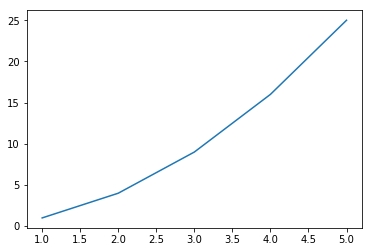

In [71]:
plt.show() # show()関数でグラフをウインドウに表示する

In [72]:
# 引数にリストを1つだけ指定した場合、そのリストはY軸の値として使用され、X軸の値はリストのインデックスの値となる
plt.plot([1, 2, 3, 4, 5])

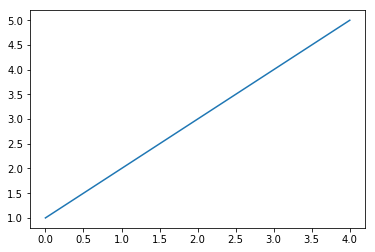

In [73]:
plt.show()

# 様々なパラメーターを指定してグラフを描画、ファイルに出力する

In [80]:
%%writefile plot_advanced_graph_to_file.py

# 様々なパラメーターを指定してグラフを描画、ファイルに出力する

import matplotlib
matplotlib.use('Agg') # 描画のバックエンドとしてデスクトップ環境が不要なAggを使う
# 日本語を描画できるようフォントを指定する
# デフォルトでは英語用のフォントが指定され、日本語が表示できない
# OS XとUbuntu用に2種類のフォントを列挙している
matplotlib.rcParams['font.sans-serif'] = 'Hiragino Kaku Gothic Pro, MigMix 1P'
import matplotlib.pyplot as plt

# plot()の第3引数には系列のスタイルを表す文字列を指定できる
# 'b'は青色、’x’はバツ印のマーカー、'-'はマーカーを実線で繋ぐことを意味する
# キーワード引数labelで指定した系列の名前は、凡例で使用される
plt.plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5], 'bx-', label='1次関数')
# スタイルの'r'は赤色、'o'は丸印のマーカー、'--'は点線を意味する
plt.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25], 'ro--', label='2次関数')
plt.xlabel('Xの値') # xlabel関数でX軸のラベルを指定する
plt.ylabel('Yの値') # ylabel関数でY軸のラベルを指定する
plt.title('matplotlibのサンプル') # title()関数でグラフのタイトルを指定する
plt.legend(loc='best') # legend関数で判例を表示する。loc='best'は最適な位置に表示することを意味する
plt.xlim(0, 6) # X軸の値の範囲を0〜6とする。ylim()関数で同様にY軸の範囲を指定できる
plt.savefig('advanced_graph.png', dpi=300) # グラフを画像ファイルに保存する

Writing plot_advanced_graph_to_file.py


In [82]:
!python plot_advanced_graph_to_file.py

# 読み込んだデータをグラフとして描画

# 時系列データを可視化する

In [92]:
%%writefile plot_historical_data.py

# 時系列データを可視化する

from datetime import datetime
import pandas as pd
import matplotlib
matplotlib.use('Agg') # 描画のバックエンドとしてデスクトップ環境が不要なAggを使う
# 日本語を描画できるようフォントを指定する
# デフォルトでは英語用のフォントが指定され、日本語が表示できない
# OS XとUbuntu用に2種類のフォントを列挙している
matplotlib.rcParams['font.sans-serif'] = 'Hiragino Kaku Gothic Pro, MigMix 1P'
import matplotlib.pyplot as plt


def main():
    # 為替データの読み込み
    df_exchange = pd.read_csv(
        'exchange.csv', encoding='cp932', header=1, names=['date', 'USD', 'rate'],
        skipinitialspace=True, index_col=0, parse_dates=True)
    # 国債金利データの読み込み
    # キーワード引数date_parserに関数parse_japanese_dateを指定、na_valuesで「-」と書かれたセルがNaNとみなされるように指定
    df_jgbcm = pd.read_csv(
        'jgbcm_all.csv', encoding='cp932', index_col=0, parse_dates=True,
        date_parser=parse_japanese_date, na_values=['-'], header=1)
    # 有効求人倍率の読み込み
    # read_excel関数の引数で不要な行と列をスキップ、西暦の列をインデックスとして使うためにindex_col=0を指定
    df_jobs = pd.read_excel('jobs.xls', skiprows=3, skip_footer=2, parse_cols='W,Y:AJ', index_col=0)
    # 縦軸が年、横軸が月になっており月ごとの変動を見るには扱いづらいので、
    # データフレームのstack()メソッドで2次元のデータフレームを1次元のシリーズに変換する
    s_jobs = df_jobs.stack()
    # シリーズのindex属性にリストを代入してインデックスを置き換える
    s_jobs.index = [parse_year_and_month(y, m) for y, m in s_jobs.index]
    
    min_date = datetime(1973, 1, 1) # X軸の最小値
    max_date = datetime.now() # X軸の最大値
    
    # 1つ目のサブプロット(為替データ)
    plt.subplot(3, 1, 1) # 3行1列の1番目のサブプロットを作成
    plt.plot(df_exchange.index, df_exchange.USD, label='ドル・円')
    plt.xlim(min_date, max_date) # X軸の範囲を指定
    plt.ylim(50, 350) # Y軸の範囲を指定
    plt.legend(loc='best') # 凡例を最適な位置に表示
    # 2つ目のサブプロット(国債金利データ)
    plt.subplot(3, 1, 2) # 3行1列の2番目のサブプロットを作成
    plt.plot(df_jgbcm.index, df_jgbcm['1年'], label='1年国債金利')  
    plt.plot(df_jgbcm.index, df_jgbcm['5年'], label='5年国債金利')  
    plt.plot(df_jgbcm.index, df_jgbcm['10年'], label='10年国債金利')
    plt.xlim(min_date, max_date) # X軸の範囲を指定
    plt.legend(loc='best') # 凡例を最適な位置に表示
    # 3つ目のサブプロット(有効求人倍率)
    plt.subplot(3, 1, 3) # 3行1列の3番目のサブプロットを作成
    plt.plot(s_jobs.index, s_jobs, label='有効求人倍率 (季節調整値)')
    plt.xlim(min_date, max_date) # X軸の範囲を指定
    plt.ylim(0.0, 2.0) # Y軸の範囲を指定
    plt.axhline(y=1, color='gray') # y=1の水平線を引く
    plt.legend(loc='best') # 凡例を最適な位置に表示
    
    plt.savefig('historical_data.png', dpi=300) # 画像を保存
    
    
def parse_japanese_date(s):
    """
    和暦の日付をdatetimeオブジェクトに変換する
    """
    base_years = {'S': 1925, 'H': 1988} #昭和・平成の0年に相当する年を定義しておく
    era = s[0] # 元号を表すアルファベット1文字を取得
    year, month, day = s[1:].split('.') # 2文字目以降を.()で分割して年月日に分ける
    year = base_years[era] + int(year) # 元号の0年に相当する年と数値に変換した年を足して西暦の年を得る
    return datetime(year, int(month), int(day)) # datetimeオブジェクトを作成する


def parse_year_and_month(year, month):
    """
    ('X年', 'Y月')の組をdatetimeオブジェクトに変換する
    """
    year = int(year[:-1]) # "年"を除去して数値に変換
    month = int(month[:-1]) # "月"を除去して数値に変換
    year += (1900 if year >= 63 else 2000) # 63年以降は19xx年、63年より前は20xx年
    return datetime(year, month, 1) # datetimeオブジェクトを作成する


if __name__ == '__main__':
    main()

Overwriting plot_historical_data.py


In [107]:
!python plot_historical_data.py

In [7]:
# 日本語フォントを指定するにはどうしたらいいのかわからない・・・

import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Hiragino Kaku Gothic Pro, Osaka, MigMix 1P' # 書籍ではOsakaが抜けておりwebで訂正
import matplotlib.pyplot as plt

min_date = datetime(1973, 1, 1) # X軸の最小値
max_date = datetime.now() # X軸の最大値

fig = plt.figure() # figはFigureクラスのオブジェクト
ax1 = fig.add_subplot(3, 1, 1) # ax1はAxesクラスのオブジェクト
ax1.plot(df_exchange.index, df_exchange.USD, label='ドル・円')
ax1.set_xlim(min_date, max_date) # X軸の範囲を指定
ax1.set_ylim(50, 350) # Y軸の範囲を指定
ax1.legend(loc='best')
fig.savefig('historical_data_OOP.png', dpi=300)

# chapter 5-4 オープンデータの収集と活用

# PDFからのデータの抽出

In [9]:
%%writefile print_pdf_textboxes.py

# PDFをパースしてテキストボックスを表示する

import sys
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams, LTContainer, LTTextBox
from pdfminer.pdfinterp import PDFPageInterpreter, PDFResourceManager
from pdfminer.pdfpage import PDFPage


def find_textboxes_recursively(layout_obj):
    """
    再帰的にテキストボックス(LTTextBox)を探して、テキストボックスのリストを取得する
    """
    # LTTextBoxを継承するオブジェクトの場合は1要素のリストを返す
    if isinstance(layout_obj, LTTextBox):
        return[layout_obj]
    
    # LTContainerを継承するオブジェクトは子要素を含むので、再帰的に探す
    if isinstance(layout_obj, LTContainer):
        boxes = []
        for child in layout_obj:
            boxes.extend(find_textboxes_recursively(child))
            
        return(boxes)
    
    return [] # その他の場合は空のリストを返す


laparams = LAParams(detect_vertical=True) # Layout Analysisのパラメーターを設定。縦書きの検出を有効にする
resource_manager = PDFResourceManager() # 共有のリソースを管理するリソースマネージャーを作成
# ページを集めるPageAggregatorオブジェクトを作成
device = PDFPageAggregator(resource_manager, laparams=laparams)
interpreter = PDFPageInterpreter(resource_manager, device) # Interpreterオブジェクトを作成

with open(sys.argv[1], 'rb') as f: # ファイルをバイナリ形式で開く
    # PDFPage.get_pages()にファイルオブジェクトを指定して、PDFPageオブジェクトを順に取得する
    # 時間がかかるファイルは、キーワード引数pagenosで処理するページ番号(0始まり)のリストを指定するとよい
    for page in PDFPage.get_pages(f):
        interpreter.process_page(page) # ページを処理する
        layout = device.get_result() # LTPageオブジェクトを取得
        
        boxes = find_textboxes_recursively(layout) # ページないのテキストボックスのリストを取得する
        # テキストボックスの左上の座標の順でテキストボックスをソートする
        # y1(y座標の値)は上に行くほど大きくなるので、正負を反転させている
        boxes.sort(key=lambda b: (-b.y1, b.x0))
        
        for box in boxes:
            print('-' * 10) # 読みやすいように区切り線を表示する
            print(box.get_text().strip()) # テキストボックス内のテキストを表示する

Overwriting print_pdf_textboxes.py


In [ ]:
!python print_pdf_textboxes.py /Users/Really/Python_ScrapingBook/000232384.pdf

# Linked Open Dataからのデータ収集

# SPARQLでデータを収集する

In [18]:
%%writefile get_museum.py

# SPARQLを使って日本の美術館を取得するスクリプト

from SPARQLWrapper import SPARQLWrapper

# SPARQLエンドポイントのURLを指定してインスタンスを作成する
sparql = SPARQLWrapper('http://ja.dbpedia.org/sparql')
# 日本の美術館を取得するクエリを設定する。
# バックスラッシュを含むので、rで始まるraw文字列を使用している
sparql.setQuery(r'''
SELECT * WHERE {
    ?s rdf:type dbpedia-owl:Museum ;
        prop-ja:所在地 ?address .
    FILTER REGEX(?address, "^\\p{Han}{2,3}[都道府県]")
} ORDER BY ?s
''')
sparql.setReturnFormat('json') # 取得するフォーマットとしてJSONを指定する
# query()でクエリを実行し、convert()でレスポンスをパースしてdictを得る
response = sparql.query().convert()

for result in response['results']['bindings']:
    print(result['s']['value'], result['address']['value']) # 抽出した変数の値を表示する

Overwriting get_museum.py


# chapter 5-5 Webページの自動操作

# RoboBrowserでGoogle検索する

In [31]:
%%writefile robobrowser_google.py

# RoboBrowserでGoogle検索する

from robobrowser import RoboBrowser

# RoboBrowserオブジェクトを作成する
# キーワード引数parserはBeautifulSoup()の第2引数として扱われる
browser = RoboBrowser(parser='html.parser')

browser.open('https://google.co.jp/') # open()メソッドでGoogleのトップページを開く

# 検索語を入力して送信する
form = browser.get_form(action='/search') # フォーム取得
form['q'] = 'Python' # フォームのqという名前のフィールドに検索語を入力
browser.submit_form(form, list(form.submit_fields.values())[0]) # 一つ目のボタン(Google検索)を押す

# 検索結果のタイトルとURLを抽出して表示する
# select()メソッドはBeautiful Soupのselect()メソッドと同じものであり、
# 引数のCSSセレクターにマッチする要素に対応するTagオブジェクトのリストを取得できる
for a in browser.select('h3 > a'):
    print(a.text)
    print(a.get('href'))

Overwriting robobrowser_google.py


In [ ]:
!python robobrowser_google.py

# Amazon.co.jpの注文履歴を取得する

In [16]:
%%writefile amazon_order_history.py

# Amazon.co.jpの注文履歴を取得する

import sys
import os
from robobrowser import RoboBrowser

# 認証の情報は環境変数から取得する
AMAZON_EMAIL = os.environ['AMAZON_EMAIL']
AMAZON_PASSWORD = os.environ['AMAZON_PASSWORD']

# RoboBrowserオブジェクトを作成する
browser = RoboBrowser(
    parser='html.parser', # Beatiful Soupで使用するパーサーを指定
    # Cookieが使用できないと表示されてログインできない問題を回避するため
    # 通常のブラウザーのUser-Agent(ここではFirefoxのもの)を使う
    user_agent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:45.0) Gecko/20100101 Firefox/45.0')


def main():
    # 注文履歴のページを開く
    print('Navigating...', file=sys.stderr)
    browser.open('https://www.amazon.co.jp/gp/css/order-history')
    
    # サインインページにリダイレクトされていることを確認する
    assert 'Amazonサインイン' in browser.parsed.title.string
    
    # name="signIn" というサインインフォームを埋める。
    # フォームのname属性の値はブラウザーの開発者ツールで確認できる。
    form = browser.get_form(attrs={'name': 'signIn'})
    form['email'] = AMAZON_EMAIL
    form['password'] = AMAZON_PASSWORD
    
    # フォームを送信する。正常にログインするにはRefererヘッダーとAccept-Languageヘッダーが必要。
    print('Signing in...', file=sys.stderr)
    browser.submit_form(form, headers={
        'Referer': browser.url,
        'Accept-Language': 'ja,en-US;q=0.7,en;q=0.3',
    })
    
    # ログインに失敗する場合は、次の行のコメントを外してHTMLのソースを確認すると良い。
    # print(browser.parsed.prettify())

    # ページャーをたどる。
    while True:
        assert '注文履歴' in browser.parsed.title.string # 注文履歴画面が表示されていることを確認する。
        
        print_order_history() # 注文履歴を表示する。
        
        link_to_next = browser.get_link('次へ') #「次へ」というテキストを持つリンクを取得する。
        if not link_to_next:
            break #「次へ」のリンクがない場合はループを抜けて終了する。
            
        print('Following link to next page...', file=sys.stderr)
        browser.follow_link(link_to_next) # 次へ」というリンクをたどる。
        
        
def print_order_history():
    """
    現在のページのすべての注文履歴を表示する
    """
    for line_item in browser.select('.order-info'):
        order = {} # 注文の情報を格納するためのdict
        # ページ内のすべての注文履歴について反復する。ブラウザーの開発者ツールでclass属性の値を確認できる
        # 注文の情報のすべての列について反復する
        for column in line_item.select('.a-column'):
            label_element = column.select_one('.label')
            value_element = column.select_one('.value')
            # ラベルと値がない列は無視する。
            if label_element and value_element:
                label = label_element.get_text().strip()
                value = value_element.get_text().strip()
                order[label] = value
        print(order['注文日'], order['合計']) # 注文の情報を表示する。
        

if __name__ == '__main__':
    main()

Overwriting amazon_order_history.py


In [ ]:
!forego run python amazon_order_history.py

# chapter 5-6 JavaScriptを使ったページのスクレイピング

# SeleniumでGoogle検索を行う

In [8]:
%%writefile selenium_google.py

# SeleniumでGoogle検索を行う

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# PhantomJSのWebDriverオブジェクトを作成する
driver = webdriver.PhantomJS()

# Googleのトップ画面を開く
driver.get('https://www.google.co.jp/')

# タイトルに'Google'が含まれていることを確認する
assert 'Google' in driver.title

# 検索語を入力して送信する
input_element = driver.find_element_by_name('q')
input_element.send_keys('Python')
input_element.send_keys(Keys.RETURN)

# タイトルに'Python'が含まれていることを確認する
assert 'Python' in driver.title

# スクリーンショットを撮る
driver.save_screenshot('search_results.png')

# 検索結果を表示する
for a in driver.find_elements_by_css_selector('h3 > a'):
    print(a.text)
    print(a.get_attribute('href'))

Overwriting selenium_google.py


In [ ]:
!python selenium_google.py

# noteのおすすめコンテンツを取得する

# Seleniumで試行錯誤しながら読み込んでみる

In [10]:
from selenium import webdriver

In [11]:
driver = webdriver.PhantomJS()

In [12]:
driver.get('https://note.mu/')

In [13]:
driver.title

'note ――つくる、つながる、とどける。'

In [14]:
driver.save_screenshot('note-1.png')

True

In [16]:
driver.set_window_size(800, 600)

In [17]:
driver.save_screenshot('note-2.png')

True

In [21]:
driver.find_elements_by_css_selector('a.p-post--basic')

[<selenium.webdriver.remote.webelement.WebElement (session="09507e30-96fa-11e7-8452-89ce99818523", element=":wdc:1505139552578")>,
 <selenium.webdriver.remote.webelement.WebElement (session="09507e30-96fa-11e7-8452-89ce99818523", element=":wdc:1505139552579")>,
 <selenium.webdriver.remote.webelement.WebElement (session="09507e30-96fa-11e7-8452-89ce99818523", element=":wdc:1505139552580")>,
 <selenium.webdriver.remote.webelement.WebElement (session="09507e30-96fa-11e7-8452-89ce99818523", element=":wdc:1505139552581")>,
 <selenium.webdriver.remote.webelement.WebElement (session="09507e30-96fa-11e7-8452-89ce99818523", element=":wdc:1505139552582")>,
 <selenium.webdriver.remote.webelement.WebElement (session="09507e30-96fa-11e7-8452-89ce99818523", element=":wdc:1505139552583")>]

In [22]:
a = driver.find_elements_by_css_selector('a.p-post--basic')[0]

In [23]:
a

<selenium.webdriver.remote.webelement.WebElement (session="09507e30-96fa-11e7-8452-89ce99818523", element=":wdc:1505139552578")>

In [24]:
a.get_attribute('href')

'https://note.mu/chitoseshizuoka/n/ndcb95b1afd79'

In [26]:
a.find_element_by_css_selector('h4').text # タイトルを取得

'ライター交流会レポート（地域振興編）'

In [27]:
a.find_element_by_css_selector('.c-post__description').text # 概要を取得

'月初めに発注されるはずの仕事が一向に発注されずとてもヒマです。でも月中より難しい仕事にかかる予定なので、うっかり仕事を入れたら自滅しそう。なので、ヒ...'

# noteのコンテンツを取得する

In [30]:
%%writefile get_note_contents.py

# noteのコンテンツを取得する (Ajax通信完了待機対応版)

import sys
import time # ← 追加
from selenium import webdriver


def main():
    """
    メインの処理
    """
    
    driver = webdriver.PhantomJS() # PhantomJSのWebDriverオブジェクトを作成する
    driver.set_window_size(800, 600) # ウインドウサイズを設定する
    
    navigate(driver) # noteのトップページに遷移する
    posts = scrape_posts(driver) # 文章コンテンツのリストを取得する
    
    # コンテンツの情報を表示する
    for post in posts:
        print(post)
        
        
def navigate(driver):
    """
    目的のページに遷移する
    """
    
    print('Navigating...', file=sys.stderr)
    driver.get('https://note.mu/') # noteのトップページを開く
    assert 'note' in driver.title # タイトルに'note'が含まれていることを確認する
    time.sleep(2)  # 2秒間待つ。 ← この行を追加
    
    
def scrape_posts(driver):
    """
    文章コンテンツのURL、タイトル、概要を含むdictのリストを取得する
    """
    
    posts = []
    
    # すべての文章コンテンツを表すa要素について反復する
    for a in driver.find_elements_by_css_selector('a.p-post--basic'):
        # URL、タイトル、概要を取得して、dictとしてリストに追加する
        posts.append({
            'url': a.get_attribute('href'),
            'title': a.find_element_by_css_selector('h4').text,
            'description': a.find_element_by_css_selector('.c-post__description').text,
        })
        
    return posts


if __name__ == '__main__':
    main()    

Overwriting get_note_contents.py


In [ ]:
!python get_note_contents.py

# おすすめノートのページから続きを読み込む処理

In [42]:
%%writefile get_more_note_contents.py

# notenのおすすめノートのページから続きを読み込む処理を追加

import sys
import time # ← 追加
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait


def main():
    """
    メインの処理
    """
    
    driver = webdriver.PhantomJS() # PhantomJSのWebDriverオブジェクトを作成する
    driver.set_window_size(800, 600) # ウインドウサイズを設定する
    
    navigate(driver) # noteのトップページに遷移する
    posts = scrape_posts(driver) # 文章コンテンツのリストを取得する
    
    # コンテンツの情報を表示する
    for post in posts:
        print(post)
        
        
def navigate(driver):
    """
    目的のページに遷移して続きのコンテンツを読み込む
    """
    
    print('Navigating...', file=sys.stderr)
    driver.get('https://note.mu/') # noteのトップページを開く
    assert 'note' in driver.title # タイトルに'note'が含まれていることを確認する
    time.sleep(2)  # 2秒間待つ ← この行を追加
    
    # ページの一番下までスクロールする
    driver.execute_script('scroll(0, document.body.scrollHeight)')
    
    print('Waiting for contents to be loaded...', file=sys.stderr)
    time.sleep(2)  # 2秒間待つ
    
    # ページの一番下までスクロールする
    driver.execute_script('scroll(0, document.body.scrollHeight)')
    
    # 10秒でタイムアウトするWebDriverWaitオブジェクトを作成する
    wait = WebDriverWait(driver, 10)
    
    print('Waiting for the more button to be clickable...', file=sys.stderr)
    # もっとみるボタンがクリック可能になるまで待つ
    button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '.btn-more')))
    
    button.click() # もっとみるボタンをクリックする
    
    print('Waiting for contents to be loaded...', file=sys.stderr)
    time.sleep(2)  # 2秒間待つ
    

def scrape_posts(driver):
    """
    文章コンテンツのURL、タイトル、概要を含むdictのリストを取得する
    """
    
    posts = []
    
    # すべての文章コンテンツを表すa要素について反復する
    for a in driver.find_elements_by_css_selector('a.p-post--basic'):
        # URL、タイトル、概要を取得して、dictとしてリストに追加する
        posts.append({
            'url': a.get_attribute('href'),
            'title': a.find_element_by_css_selector('h4').text,
            'description': a.find_element_by_css_selector('.c-post__description').text,
        })
        
    return posts


if __name__ == '__main__':
    main()    

Overwriting get_more_note_contents.py


In [ ]:
!python get_more_note_contents.py

# おすすめノートのページからRSSフィードを作成する

In [1]:
%%writefile note_rss.py

# おすすめノートのページからRSSフィードを作成する
# カレントディレクトリにrecommend.rss(RSS2.0に従ったXML)が生成される

import sys
import time # ← 追加
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import feedgenerator


def main():
    """
    メインの処理
    """
    
    driver = webdriver.PhantomJS() # PhantomJSのWebDriverオブジェクトを作成する
    driver.set_window_size(800, 600) # ウインドウサイズを設定する
    
    navigate(driver) # noteのトップページに遷移する
    posts = scrape_posts(driver) # 文章コンテンツのリストを取得する
    
    # RSSフィードとして保存する
    with open('recommend.rss', 'w') as f:
        save_as_feed(f, posts)
        
        
def navigate(driver):
    """
    目的のページに遷移して続きのコンテンツを読み込む
    """
    
    print('Navigating...', file=sys.stderr)
    driver.get('https://note.mu/') # noteのトップページを開く
    assert 'note' in driver.title # タイトルに'note'が含まれていることを確認する
    time.sleep(2)  # 2秒間待つ ← この行を追加
    
    # ページの一番下までスクロールする
    driver.execute_script('scroll(0, document.body.scrollHeight)')
    
    print('Waiting for contents to be loaded...', file=sys.stderr)
    time.sleep(2)  # 2秒間待つ
    
    # ページの一番下までスクロールする
    driver.execute_script('scroll(0, document.body.scrollHeight)')
    
    # 10秒でタイムアウトするWebDriverWaitオブジェクトを作成する
    wait = WebDriverWait(driver, 10)
    
    print('Waiting for the more button to be clickable...', file=sys.stderr)
    # もっとみるボタンがクリック可能になるまで待つ
    button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '.btn-more')))
    
    button.click() # もっとみるボタンをクリックする
    
    print('Waiting for contents to be loaded...', file=sys.stderr)
    time.sleep(2)  # 2秒間待つ
    

def scrape_posts(driver):
    """
    文章コンテンツのURL、タイトル、概要を含むdictのリストを取得する
    """
    
    posts = []
    
    # すべての文章コンテンツを表すa要素について反復する
    for a in driver.find_elements_by_css_selector('a.p-post--basic'):
        # URL、タイトル、概要を取得して、dictとしてリストに追加する
        posts.append({
            'url': a.get_attribute('href'),
            'title': a.find_element_by_css_selector('h4').text,
            'description': a.find_element_by_css_selector('.c-post__description').text,
        })
        
    return posts


def save_as_feed(f, posts):
    """
    文章コンテンツのリストをフィードとして保存する
    """
    
    # フィードを表すRss201rev2Feedオブジェクトを作成する
    feed = feedgenerator.Rss201rev2Feed(
        title='おすすめノート', # フィードのタイトル
        link='https://note.mu/',  # 　フィードに対応するwebサイトのURL
        description='おすすめノート') # フィードの概要
    
    for post in posts:
        # フィードにアイテムを追加する
        # キーワード引数unique_idは、アイテムを一意に識別するユニークなIDを指定する
        # 必須ではないが、このIDを指定しておくとRSSリーダーがアイテムの重複なく扱える
        # 可能性が高まるので、ここではコンテンツのURLを指定している
        feed.add_item(title=post['title'], link=post['url'],
                     description=post['description'], unique_id=post['url'])
        
    feed.write(f, 'utf-8') # ファイルオブジェクトに書き込む。第2引数にエンコーディングを指定する
    

if __name__ == '__main__':
    main()    

Writing note_rss.py


In [2]:
!python note_rss.py

Navigating...
Waiting for contents to be loaded...
Waiting for the more button to be clickable...
Waiting for contents to be loaded...


In [3]:
# !python -m http.server

# chapter 5-7 取得したデータの活用

# ジオコーディングによる位置情報の取得

In [ ]:
# jqコマンドはJSONに対してクエリを実行して一部を抽出できるコマンド
# jq . を実行すると標準入力に与えたJSON文字列が整形して表示される
# brew install jq

In [27]:
# jq . あり
!curl -s 'https://map.yahooapis.jp/geocode/V1/geoCoder?appid=dj00aiZpPTgxQUZmbUZBcWx2TCZzPWNvbnN1bWVyc2VjcmV0Jng9ZjE-\
&output=json&query=東京都台東区上野公園7番7号' | jq .

{
  "ResultInfo": {
    "Count": 1,
    "Total": 1,
    "Start": 1,
    "Status": 200,
    "Description": "",
    "Copyright": "",
    "Latency": 0.054
  },
  "Feature": [
    {
      "Id": "13106.8.7.7",
      "Gid": "",
      "Name": "東京都台東区上野公園7-7",
      "Geometry": {
        "Type": "point",
        "Coordinates": "139.77589247,35.71533133",
        "BoundingBox": "139.77029247,35.70973133 139.78149247,35.72093133"
      },
      "Category": [],
      "Description": "",
      "Style": [],
      "Property": {
        "Uid": "0505dcfa8557a4206edfa281475b0c83f82e9283",
        "CassetteId": "b22fee69b0dcaf2c2fe2d6a27906dafc",
        "Yomi": "トウキョウトタイトウクウエノコウエン",
        "Country": {
          "Code": "JP",
          "Name": "日本"
        },
        "Address": "東京都台東区上野公園7-7",
        "GovernmentCode": "13106",
        "AddressMatchingLevel": "6",
        "AddressType": "地番・戸番"
      }
    }
  ]
}


In [23]:
# jq . なし
!curl -s 'https://map.yahooapis.jp/geocode/V1/geoCoder?appid=dj00aiZpPTgxQUZmbUZBcWx2TCZzPWNvbnN1bWVyc2VjcmV0Jng9ZjE-\
&output=json&query=東京都台東区上野公園7番7号'

{"ResultInfo":{"Count":1,"Total":1,"Start":1,"Status":200,"Description":"","Copyright":"","Latency":0.056},"Feature":[{"Id":"13106.8.7.7","Gid":"","Name":"\u6771\u4eac\u90fd\u53f0\u6771\u533a\u4e0a\u91ce\u516c\u57127-7","Geometry":{"Type":"point","Coordinates":"139.77589247,35.71533133","BoundingBox":"139.77029247,35.70973133 139.78149247,35.72093133"},"Category":[],"Description":"","Style":[],"Property":{"Uid":"0505dcfa8557a4206edfa281475b0c83f82e9283","CassetteId":"b22fee69b0dcaf2c2fe2d6a27906dafc","Yomi":"\u30c8\u30a6\u30ad\u30e7\u30a6\u30c8\u30bf\u30a4\u30c8\u30a6\u30af\u30a6\u30a8\u30ce\u30b3\u30a6\u30a8\u30f3","Country":{"Code":"JP","Name":"\u65e5\u672c"},"Address":"\u6771\u4eac\u90fd\u53f0\u6771\u533a\u4e0a\u91ce\u516c\u57127-7","GovernmentCode":"13106","AddressMatchingLevel":"6","AddressType":"\u5730\u756a\u30fb\u6238\u756a"}}]}

In [22]:
# 結果の数だけを抽出する
!curl -s 'https://map.yahooapis.jp/geocode/V1/geoCoder?appid=dj00aiZpPTgxQUZmbUZBcWx2TCZzPWNvbnN1bWVyc2VjcmV0Jng9ZjE-\
&output=json&query=東京都台東区上野公園7番7号' | jq .ResultInfo.Count

1


In [26]:
# 結果と緯度だけを抽出する
!curl -s 'https://map.yahooapis.jp/geocode/V1/geoCoder?appid=dj00aiZpPTgxQUZmbUZBcWx2TCZzPWNvbnN1bWVyc2VjcmV0Jng9ZjE-\
&output=json&query=東京都台東区上野公園7番7号' | jq .Feature[0].Geometry.Coordinates

"139.77589247,35.71533133"


# code 5.27 SPARQLとジオコーダAPIを使って日本の美術館の位置情報を取得する

In [34]:
%%writefile get_museum_with_location.py

# 日本の美術館の位置情報を取得する

import sys
import os
import json
import dbm
from urllib.request import urlopen
from urllib.parse import urlencode
from SPARQLWrapper import SPARQLWrapper


def main():
    features = [] # 美術館の情報を格納するためのリスト
    
    for museum in get_museums():
        # ラベルがある場合はラベルを、ない場合はsの値を取得
        label = museum.get('label', museum['s'])
        address = museum['address']
        
        if 'lon_degree' in museum:
            # 位置情報が含まれている場合は、経度と緯度を60度数(度分秒)から10進数に変換する
            # 10進数の度 = 60進数の度 + 60進数の分 / 60 + 60進数の秒 / 3600
            lon = float(museum['lon_degree']) + float(museum['lon_minute']) / 60 + \
                float(museum['lon_second']) / 3600
            lat = float(museum['lat_degree']) + float(museum['lat_minute']) / 60 + \
                float(museum['lat_second']) / 3600
                
        else:
            # 位置情報が含まれない場合は、住所をジオコーディングして経度と緯度を取得する
            lon, lat = geocode(address)
            
        print(label, address, lon, lat) # 変数の値を表示
        
        # ジオコーディングしても位置情報を取得できなかった場合はfeaturesに含めない
        if lon is None:
            continue
            
        # featuresに美術館の情報をGeoJSONのFeatureの形式で追加する
        features.append({
            'type': 'Feature',
            'geometry': {'type': 'Point', 'coordinates': [lon, lat]},
            'properties': {'label': label, 'address': address},
        })
    
    # GeoJSONのFeatureCollectionの形式でdictを作成する
    feature_collection = {
        'type': 'FeatureCollection',
        'features': features,
    }
    # FeatureCollectionを.geojsonという拡張子のファイルに書き出す
    with open('museum.geojson', 'w') as f:
        json.dump(feature_collection, f)
    
    
def get_museums():
    """
    SPARQLを使ってDBPedia Japaneseから美術館の情報を取得する
    """
    
    print('Executing SPARQL query...', file=sys.stderr)
    
    # SPARQLエンドポイントのURLを指定してインスタンスを作成する
    sparql = SPARQLWrapper('http://ja.dbpedia.org/sparql')
    # 日本の美術館を取得するクエリを設定する。
    # バックスラッシュを含むので、rで始まるraw文字列を使用している
    sparql.setQuery(r'''
    SELECT * WHERE {
        ?s rdf:type dbpedia-owl:Museum ;
        prop-ja:所在地 ?address .
        OPTIONAL { ?s rdfs:label ?label . }
        OPTIONAL {
        ?s prop-ja:経度度 ?lon_degree ;
            prop-ja:経度分 ?lon_minute ;
            prop-ja:経度秒 ?lon_second ;
            prop-ja:緯度度 ?lat_degree ;
            prop-ja:緯度分 ?lat_minute ;
            prop-ja:緯度秒 ?lat_second .
        }
        FILTER REGEX(?address, "^\\p{Han}{2,3}[都道府県]")
    } ORDER BY ?s
    ''')
    # 取得するフォーマットとしてJSONを指定する
    sparql.setReturnFormat('json')
    # query()でクエリを実行し、convert()でレスポンスをパースしてdictを得る
    response = sparql.query().convert()
    
    print('Got {0} results'.format(len(response['results']['bindings']), file=sys.stderr))
    
    # クエリの実行結果を反復処理する
    for result in response['results']['bindings']:
        # 扱いやすいように{変数名1: 値1, 変数名2: 値2, ...}という形式のdictをyieldする
        # resultを加工した辞書を得るために、辞書内包表記というリスト内包表記に似た表記法を使う
        yield {name: binding['value'] for name, binding in result.items()}
        
        
# Yahoo!ジオコーダAPIのURL
YAHOO_GEOCODER_API_URL = 'https://map.yahooapis.jp/geocode/V1/geoCoder'
# DBM(ファイルを使ったキーバリュー型のDB)をジオコーディング結果のキャッシュとして使用する
# この変数はdictと同じように扱える
geocoding_cache = dbm.open('geocoding.db', 'c')


def geocode(address):
    """
    引数で指定した住所をジオコーディングして、経度と緯度のペアを返す
    """
    
    if address not in geocoding_cache:
        # 住所がキャッシュに存在しない場合はYahoo!ジオコーダAPIでジオコーディングする
        print('Geocoding {0}...'.format(address), file=sys.stderr)
        url = YAHOO_GEOCODER_API_URL + '?' + urlencode({
            # アプリケーションIDは環境変数から取得する
            'appid': os.environ['YAHOOJAPAN_APP_ID'],
            'output': 'json',
            'query': address,
        })
        
        response_text = urlopen(url).read()
        # APIのレスポンスをキャッシュに格納する
        # キーや値にはbytes型しか使えないが、str型は自動的にbytes型に変換される
        geocoding_cache[address] = response_text
        
    # キャッシュ内のAPIレスポンスをdictに変換
    # 値はbytes型なので、文字列として扱うにはデコードが必要
    response = json.loads(geocoding_cache[address].decode('utf-8'))
    
    if 'Feature' not in response:
        # ジオコーディングで結果が得られなかった場合はNoneのペアを返す
        return (None, None)
    
    # Coordinateというキーの値を , で分割
    coordinates = response['Feature'][0]['Geometry']['Coordinates'].split(',')
    # floatnのペアに変換して返す
    return (float(coordinates[0]), float(coordinates[1]))


if __name__ == '__main__':
    main()

Overwriting get_museum_with_location.py


In [ ]:
!forego run python get_museum_with_location.py